# Intro

# Libraries

In [1]:
import sys
sys.path.append("../")

In [34]:
from typing import Tuple

import logging
import os
import gc
import shutil
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
import scipy.stats as st
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.a2c import A2C, MlpPolicy
import scipy.stats as st
import tensorflow.keras as krs
import src.algorithms.algo_utils as autil
import src.algorithms.advantages as adv
import src.algorithms.dummy as dummy
from src.envs.resource_allocation_env import DiscreteProjectsEnv, DiscreteProjectOptimizerAgent
import src.algorithms.policy_gradient.tf2.ppo as ppo
import src.models.base_models.tf2.policy_nets as policy_nets
import src.models.base_models.tf2.value_nets as vnets
from tensorflow_probability.python.distributions import TruncatedNormal
from tqdm.auto import tqdm

import mlflow.tensorflow as mlftf
import mlflow as mlf

In [37]:
from importlib import reload

In [38]:
dummy = reload(dummy)

# Env setup

In [3]:
log = logging.getLogger()
log.setLevel(logging.INFO)
std_handler = logging.StreamHandler(sys.stdout)
log.addHandler(std_handler)

In [4]:
ENV_SIZE = 300

In [5]:
env = DiscreteProjectsEnv(
        start_resource=100,
        start_cash=100,
        upkeep_cost=-1,
        min_payout=-0.5,
        max_payout=1.5,
        payout_mean=1.0,
        payout_std=0.5,
        size=ENV_SIZE,
        balance_is_reward=False,
        stochastic=True)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.n

/anaconda/envs/py39/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


<AxesSubplot:>

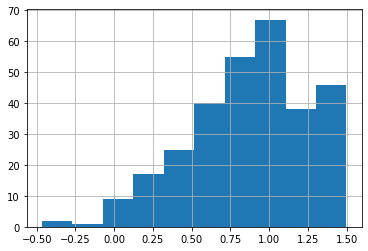

In [7]:
env.projects.proj_1_payouts.hist()

<AxesSubplot:>

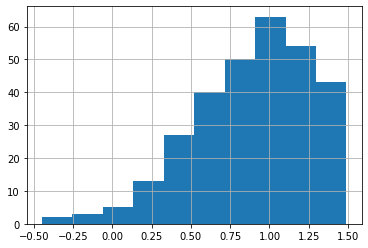

In [8]:
env.projects.proj_2_payouts.hist()

# Agents

In [10]:
krs.backend.clear_session()
print(gc.collect())

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.n

initializer = krs.initializers.HeNormal()
policy_net = policy_nets.DiscretePolicyNet(a_dim, [128, 128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

policy_opt = krs.optimizers.Adam(0.0003)
value_opt = krs.optimizers.Adam(0.0003)

agent = ppo.PPO(policy_net, value_net, policy_opt, value_opt, adv.GAE, n_agents=3, clipping_eps=0.2, entropy_coef=0.0001)


213


In [11]:
dummy_agent = DiscreteProjectOptimizerAgent(env)

In [39]:
random_agent = dummy.DummyAgent(env)

# Evaluate before training

In [12]:
ppo_scores_before = autil.evaluate_algorithm(agent, env, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
dummy_scores = autil.evaluate_algorithm(dummy_agent, env, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [40]:
random_scores = autil.evaluate_algorithm(random_agent, env, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

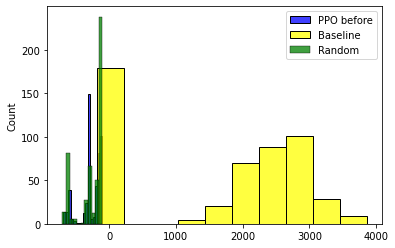

In [41]:
sns.histplot(ppo_scores_before, color='blue', label='PPO before')
sns.histplot(dummy_scores, color='yellow', label='Baseline')
sns.histplot(random_scores, color='green', label='Random')
plt.legend()

# Train agent

In [15]:
tf_logpath = "./ppo_simple_projectenv_tensorboard"
if os.path.exists(tf_logpath):
    shutil.rmtree(tf_logpath)
writer = tf.summary.create_file_writer(tf_logpath)

In [16]:
env.reset()
with writer.as_default():
    ppo_scores_after = agent.train(env, 800, max_steps=ENV_SIZE, average_n_last=30, print_interval=10, epochs=5, batch_size=64, log=log,
                         gamma=0.99, clip_action=False, max_train_sec=30*60)

Ep: 0/266  Rewards avg.: -157.569  Loss avg.: 0.508  Time passed: 0.013/30.000
Ep: 10/266  Rewards avg.: -253.654  Loss avg.: 0.772  Time passed: 0.067/30.000
Ep: 20/266  Rewards avg.: -218.100  Loss avg.: 0.833  Time passed: 0.167/30.000
Ep: 30/266  Rewards avg.: -183.217  Loss avg.: 0.743  Time passed: 0.291/30.000
Ep: 40/266  Rewards avg.: -98.348  Loss avg.: 0.807  Time passed: 0.528/30.000
Ep: 50/266  Rewards avg.: -64.404  Loss avg.: 0.619  Time passed: 0.659/30.000
Ep: 60/266  Rewards avg.: -65.780  Loss avg.: 0.753  Time passed: 0.771/30.000
Ep: 70/266  Rewards avg.: -69.910  Loss avg.: 0.744  Time passed: 0.939/30.000
Ep: 80/266  Rewards avg.: 129.480  Loss avg.: 0.736  Time passed: 1.574/30.000
Ep: 90/266  Rewards avg.: 766.688  Loss avg.: 0.928  Time passed: 2.428/30.000
Ep: 100/266  Rewards avg.: 1662.370  Loss avg.: 1.138  Time passed: 3.356/30.000
Ep: 110/266  Rewards avg.: 2403.128  Loss avg.: 1.184  Time passed: 4.287/30.000
Ep: 120/266  Rewards avg.: 2351.650  Loss avg

# Eval after train

In [17]:
results_dir = "ppo_discrete_env_results"

In [19]:
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
    os.mkdir(results_dir)

# Compare results

In [20]:
ppo_eval_scores_after_500 = autil.evaluate_algorithm(agent, env, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

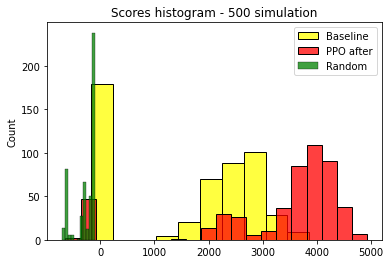

In [42]:
sns.histplot(dummy_scores, color='yellow', label='Baseline')
sns.histplot(ppo_eval_scores_after_500, color='red', label='PPO after')
sns.histplot(random_scores, color='green', label='Random')
plt.title("Scores histogram - 500 simulation")
plt.legend()
plt.savefig(f"./{results_dir}/scores_histogram.png")

In [44]:
result_df = pd.DataFrame({
    'PPO before': ppo_scores_before, 
    'random': random_scores,
    'PPO after': ppo_eval_scores_after_500,
    'baseline': dummy_scores, })
result_df.describe()

,PPO before,random,PPO after,baseline
count,500.000000,500.000000,500.000000,500.000000
mean,-276.579881,-267.272951,3310.519252,1575.678831
std,160.941346,189.911325,1308.513893,1320.515495
min,-683.790746,-699.000000,-642.572533,-176.033663
25%,-300.000000,-341.000000,2969.962179,-106.993587
50%,-300.000000,-157.000000,3801.555996,2141.871705
75%,-147.894269,-118.269788,4114.554665,2684.589808
max,-100.000000,-100.000000,4921.815940,3859.277054


In [45]:
result_df.to_csv(f"./{results_dir}/scores.csv", index=False)

In [46]:
stat, pval = st.levene(*[result_df[c] for c in result_df.columns])
pval.round(4)

0.0

In [47]:
melted_df = result_df.melt(var_name='model')
result = pg.welch_anova(melted_df, dv='value', between='model')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,model,3,999.544207,1549.949533,0.0,0.716569


In [48]:
pg.pairwise_gameshowell(melted_df, dv='value', between='model', effsize='cohen')

,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,PPO after,PPO before,3310.519252,-276.579881,3587.099133,58.959490,60.840064,514.094188,0.001000,3.847863
1,PPO after,baseline,3310.519252,1575.678831,1734.840421,83.138075,20.866978,997.916819,0.001000,1.319744
2,PPO after,random,3310.519252,-267.272951,3577.792202,59.131631,60.505555,520.012752,0.001000,3.826707
3,PPO before,baseline,-276.579881,1575.678831,-1852.258712,59.492240,-31.134459,513.821187,0.001000,-1.969116
4,PPO before,random,-276.579881,-267.272951,-9.306931,11.132693,-0.836000,971.853956,0.815994,-0.052873
5,baseline,random,1575.678831,-267.272951,1842.951781,59.662844,30.889439,519.632864,0.001000,1.953620


In [49]:
import pickle
pickle.dump(value_net, open(f"./{results_dir}/value_net.pkl", "wb"))
policy_net.save(f"./{results_dir}/policy_net.tf", save_format='tf')

Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
INFO:tensorflow:Assets written to: ram://929843d0-6427-4c0b-8373-5236efd7c2b6/assets
Assets written to: ram://929843d0-6427-4c0b-8373-5236efd7c2b6/assets
INFO:tensorflow:Assets written to: ./ppo_discrete_env_results/policy_net.tf/assets
Assets written to: ./ppo_discrete_env_results/policy_net.tf/assets


In [50]:
params = {}
for k, v in agent.__dict__.items():
    if k != 'policy_net' and k != 'value_net' and 'opt' not in k and 'clipper' not in k:
        params[k] = v

In [51]:
pickle.dump(params, open(f"./{results_dir}/agent_data.pkl", "wb"))

In [52]:
actions = []
for i in tqdm(range(100)):
    done = False
    s = env.reset()
    while not done:
        a, _ = agent.choose_action(s=s)
        sprime, r, done, _  = env.step(a)
        s = sprime
        actions.append(int(a))

  0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
pd.value_counts(actions)

2    21041
1     5075
0     1530
6       80
8        2
5        1
4        1
7        1
dtype: int64